### Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import time

### Data Preprocessing

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("feyzazkefe/trashnet")

# print("Path to dataset files:", path)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
data_dir = r'C:\Users\baoba\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1\dataset-resized'
classes = os.listdir(data_dir)
print(classes)
print(device)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cuda


In [4]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transformations)

In [5]:
import matplotlib.pyplot as plt
def show_image(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label: glass (Class No: 1)


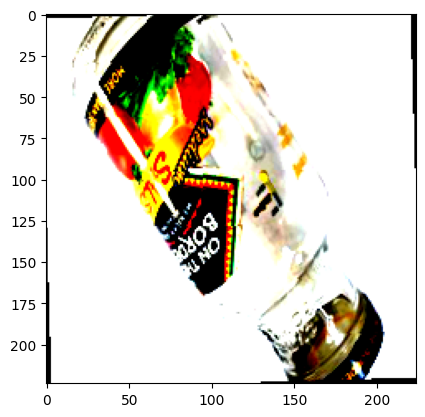

In [6]:
img, label = dataset[536]
show_image(img, label)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(2021, 252, 254)

In [9]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset, BATCH_SIZE*2, num_workers = 4, pin_memory = True)

### Resnet

In [10]:
from models import BasicBlock, Bottleneck, ResNet

In [11]:
from models import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
class GarbageClassifier(ImageClassificationBase):
    def __init__(self, num_classes, version):
        super().__init__()
        if version==18:
            network = ResNet18(num_classes)
        elif version==34:
            network = ResNet34(num_classes)
        elif version==50:
            network = ResNet50(num_classes)
        elif version==101:
            network = ResNet101(num_classes)
        elif version==152:
            network = ResNet152(num_classes)
        self.network = network
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return self.network(xb)
num_classes = len(classes)
model_18 = GarbageClassifier(num_classes, 18)
model_34 = GarbageClassifier(num_classes, 34)
model_50 = GarbageClassifier(num_classes, 50)
model_101 = GarbageClassifier(num_classes, 101)
model_152 = GarbageClassifier(num_classes, 152)
model_18.to(device)
model_34.to(device)
model_50.to(device)
model_101.to(device)
model_152.to(device)

Using cuda


GarbageClassifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (downsample): Sequential(
          (0): Conv2d(64

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs.append(model.validation_step((images, labels)))
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    total_train_start = time.time()    

    for epoch in range(epochs):
        epoch_start = time.time() 

        # ===== Training Phase =====
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            loss = model.training_step((images, labels))
            train_losses.append(loss)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # ===== Validation Phase =====
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        model.epoch_end(epoch, result)
        
        # Thời gian epoch
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{epochs}] finished in {epoch_time:.2f} sec")

        # Lưu vào lịch sử
        result['epoch_time'] = epoch_time
        history.append(result)

    total_time = time.time() - total_train_start
    print(f"\nTotal training time: {total_time:.2f} sec ({total_time/60:.2f} min)")

    return history


In [15]:
from models import load_or_train_model

num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

models_dict = {}
histories = {}

# Load hoặc train model - nếu .pth file tồn tại sẽ load, không thì train
for version in [18, 34, 50, 101, 152]:
    model_path = f'resnet{version}_model.pth'
    
    # Kiểm tra xem model đã train chưa
    if os.path.exists(model_path):
        print(f"Loading pre-trained ResNet{version}...")
        model = torch.load(model_path, map_location=device)
        model.eval()
        models_dict[version] = model
    else:
        # Train model mới
        print(f"Training ResNet{version}... (Model file not found)")
        model = GarbageClassifier(num_classes, version)
        model.to(device)
        
        # Train
        history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
        histories[version] = history
        
        # Save model
        torch.save(model, model_path)
        print(f"Model saved to '{model_path}'\n")
        
        model.eval()
        models_dict[version] = model

# Gán models cho biến toàn cục
model_18 = models_dict[18]
model_34 = models_dict[34]
model_50 = models_dict[50]
model_101 = models_dict[101]
model_152 = models_dict[152]

Training ResNet18... (Model file not found)
Epoch 1: train_loss: 0.9529, val_loss: 0.5650, val_acc: 0.8026
Epoch [1/20] finished in 33.18 sec
Epoch 2: train_loss: 0.4409, val_loss: 0.4165, val_acc: 0.8695
Epoch [2/20] finished in 32.91 sec
Epoch 3: train_loss: 0.2786, val_loss: 0.3040, val_acc: 0.8938
Epoch [3/20] finished in 32.24 sec
Epoch 4: train_loss: 0.1942, val_loss: 0.3136, val_acc: 0.8578
Epoch [4/20] finished in 33.40 sec
Epoch 5: train_loss: 0.1402, val_loss: 0.2836, val_acc: 0.8932
Epoch [5/20] finished in 32.65 sec
Epoch 6: train_loss: 0.1053, val_loss: 0.2642, val_acc: 0.9055
Epoch [6/20] finished in 31.56 sec
Epoch 7: train_loss: 0.0916, val_loss: 0.2344, val_acc: 0.9169
Epoch [7/20] finished in 31.58 sec
Epoch 8: train_loss: 0.0598, val_loss: 0.2617, val_acc: 0.9133
Epoch [8/20] finished in 31.17 sec
Epoch 9: train_loss: 0.0571, val_loss: 0.2300, val_acc: 0.9289
Epoch [9/20] finished in 31.31 sec
Epoch 10: train_loss: 0.0561, val_loss: 0.2297, val_acc: 0.9292
Epoch [10/

In [16]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0).to(device)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [17]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, num_workers=4, pin_memory=True)

def evaluate_model_on_test(model, data_loader, device, model_name="Model"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Độ chính xác của {model_name} trên tập test ({total} ảnh): {accuracy:.2f}%')
    return accuracy
print("--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---")

# Đánh giá ResNet18
acc_18 = evaluate_model_on_test(model_18, test_loader, device, "ResNet18")

# Đánh giá ResNet50
acc_34 = evaluate_model_on_test(model_34, test_loader, device, "ResNet34")

# Đánh giá ResNet50
acc_50 = evaluate_model_on_test(model_50, test_loader, device, "ResNet50")

# Đánh giá ResNet101
acc_101 = evaluate_model_on_test(model_101, test_loader, device, "ResNet101")

# Đánh giá ResNet152
acc_152 = evaluate_model_on_test(model_152, test_loader, device, "ResNet152")

--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---
Độ chính xác của ResNet18 trên tập test (254 ảnh): 91.34%
Độ chính xác của ResNet34 trên tập test (254 ảnh): 90.16%
Độ chính xác của ResNet50 trên tập test (254 ảnh): 92.52%
Độ chính xác của ResNet101 trên tập test (254 ảnh): 92.91%
Độ chính xác của ResNet152 trên tập test (254 ảnh): 92.91%


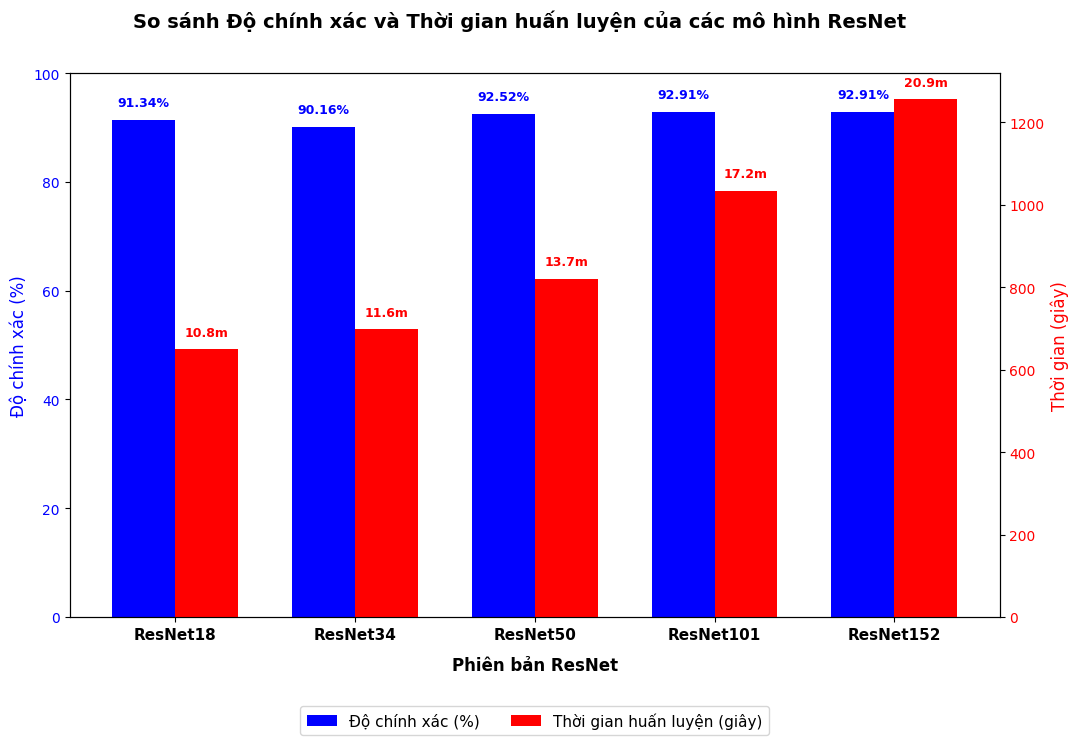

In [18]:
model_versions = [18, 34, 50, 101, 152]

# Tạo dictionary lưu độ chính xác
final_accuracies = {
    18: acc_18,
    34: acc_34,
    50: acc_50,
    101: acc_101,
    152: acc_152
}

accuracies = [final_accuracies[v] for v in model_versions]

# Tính training time
training_times = []
for v in model_versions:
    if v in histories:
        time_total = sum(epoch['epoch_time'] for epoch in histories[v])
    else:
        time_total = 0
    training_times.append(time_total)

x = np.arange(len(model_versions))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 8)) 
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, accuracies, width, label='Độ chính xác (%)', color='blue')
ax1.set_ylabel('Độ chính xác (%)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 100])

for i, (bar, val) in enumerate(zip(bars1, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2, 
             f'{val:.2f}%',
             ha='center', va='bottom', fontsize=9, color='blue', fontweight='bold')

bars2 = ax2.bar(x + width/2, training_times, width, label='Thời gian huấn luyện (giây)', color='red')
ax2.set_ylabel('Thời gian (giây)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

for i, (bar, val) in enumerate(zip(bars2, training_times)):
    height = bar.get_height()
    if val > 0:
        time_str = f'{val:.0f}s' if val < 60 else f'{val/60:.1f}m'
        ax2.text(bar.get_x() + bar.get_width()/2., height + (max(training_times)*0.02), 
                time_str,
                ha='center', va='bottom', fontsize=9, color='red', fontweight='bold')

ax1.set_xlabel('Phiên bản ResNet', fontsize=12, fontweight='bold', labelpad=10) 
ax1.set_xticks(x)
ax1.set_xticklabels([f'ResNet{v}' for v in model_versions], fontsize=11, fontweight='bold')

fig.suptitle('So sánh Độ chính xác và Thời gian huấn luyện của các mô hình ResNet', fontsize=14, fontweight='bold', y=0.96)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()


ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.15), 
           ncol=2, fontsize=11)

plt.subplots_adjust(bottom=0.2) 

plt.show()

In [19]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0).to(device)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.1834733].


Label: metal (Class No: 2)
Label: metal , Predicted: metal
Label: metal , Predicted: metal
Label: metal , Predicted: metal
Label: metal , Predicted: metal
Label: metal , Predicted: metal


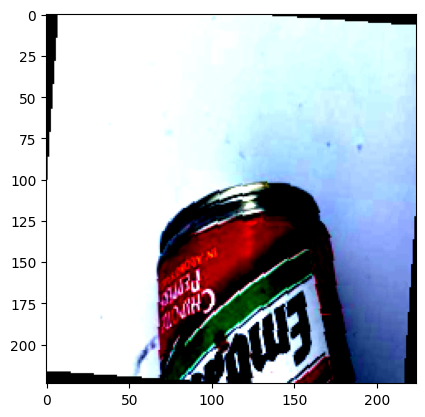

In [20]:
img, label = test_dataset[36]
show_image(img, label)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_18))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_34))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_50))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_101))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_152))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.2914162].


Label: metal (Class No: 2)
Label: metal , Predicted: metal
Label: metal , Predicted: glass
Label: metal , Predicted: metal
Label: metal , Predicted: metal
Label: metal , Predicted: metal


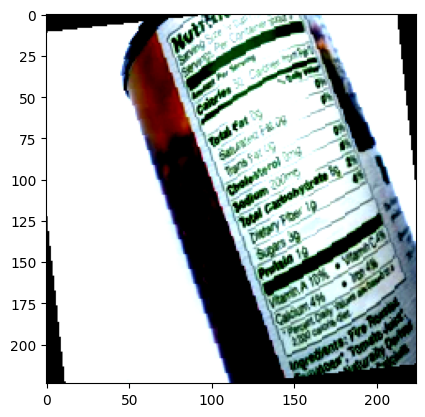

In [21]:
img, label = test_dataset[19]
show_image(img, label)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_18))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_34))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_50))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_101))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_152))

In [22]:
from PIL import Image
def predict_external_image(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transformations(img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, dim=1)
    
    predicted_class = classes[preds[0].item()]
    
    # Hiển thị ảnh và kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Dự đoán: {predicted_class}")
    plt.show()
    
    return predicted_class

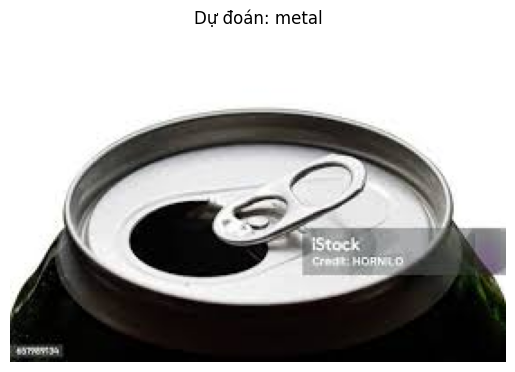

'metal'

In [23]:
predict_external_image('image.jpg', model_18)

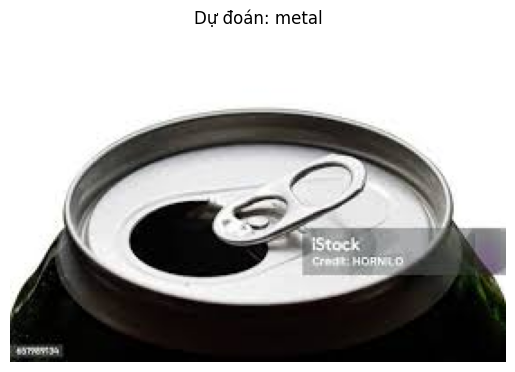

'metal'

In [24]:
predict_external_image('image.jpg', model_34)

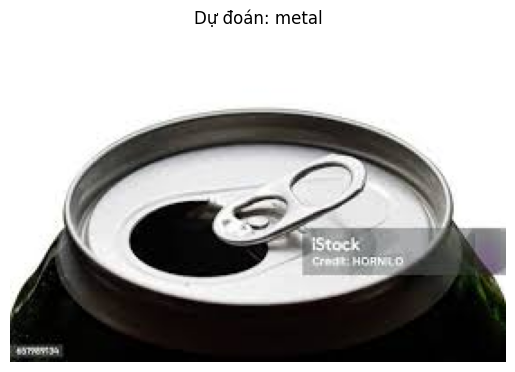

'metal'

In [25]:
predict_external_image('image.jpg', model_50)

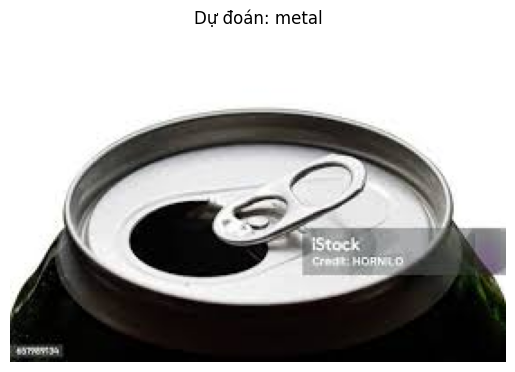

'metal'

In [26]:
predict_external_image('image.jpg', model_101)

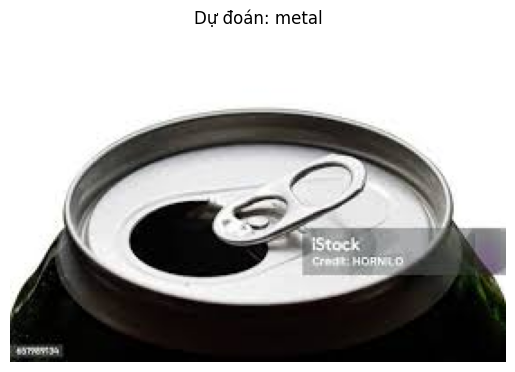

'metal'

In [27]:
predict_external_image('image.jpg', model_152)